In [5]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

import tensorflow as tf
from keras import layers
from keras.utils import get_file
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle
from sklearn.metrics import classification_report,accuracy_score

from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import  ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout

from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras import datasets
from tensorflow.keras import Input
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam

In [6]:
from google.colab import drive
drive.mount('/content/drive') 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
gar_path = '/content/drive/MyDrive/Garbage classification/Garbage classification'
waste_labels = {"cardboard":0, "glass":1, "metal":2, "paper":3, "plastic":4, "trash":5}

In [8]:
paths = []
labels = []
for dirname, _, filenames in os.walk(gar_path):
  for filename in filenames:
    if '.jpg' in filename:
      path = dirname + '/' + filename
      paths.append(path)
      
      if 'cardboard' in path:
        labels.append('0') # fcardboard = 0
      elif 'glass' in path:
        labels.append('1') # glass = 1
      elif 'metal' in path:
        labels.append('2') # metal = 2
      elif 'paper' in path:
        labels.append('3') # paper = 3
      elif 'plastic' in path:
        labels.append('4') # plastic = 4
      elif 'trash' in path:
        labels.append('5') # trash = 5


print(len(paths), len(labels))

2404 2404


In [9]:
data_df = pd.DataFrame({'path' : paths, 'label' : labels})
data_df

,path,label
0,/content/drive/MyDrive/Garbage classification/...,4
1,/content/drive/MyDrive/Garbage classification/...,4
2,/content/drive/MyDrive/Garbage classification/...,4
3,/content/drive/MyDrive/Garbage classification/...,4
4,/content/drive/MyDrive/Garbage classification/...,4
...,...,...
2399,/content/drive/MyDrive/Garbage classification/...,3
2400,/content/drive/MyDrive/Garbage classification/...,3
2401,/content/drive/MyDrive/Garbage classification/...,3
2402,/content/drive/MyDrive/Garbage classification/...,3


In [10]:
print(f'Number of pictures: {data_df.shape[0]}\n')
print(f'Number of different labels: {len(data_df.label.unique())}\n')
print(f'Labels: {data_df.label.unique()}')

Number of pictures: 2404

Number of different labels: 6

Labels: ['4' '1' '5' '0' '2' '3']


In [23]:
data_gen = ImageDataGenerator(horizontal_flip=True,
                             vertical_flip=True,
                             validation_split=0.2,
                             rescale=1./255,
                             shear_range=0.1,
                             zoom_range=0.1,
                             width_shift_range=0.1,
                             height_shift_range=0.1)

val_gen = ImageDataGenerator(validation_split=0.2,
                             rescale = 1./255)


tr_flow_gen = data_gen.flow_from_directory(directory = gar_path,
                                         target_size = (128, 128), # 모델에 들어갈 인풋 이미지사이즈
                                         class_mode='categorical', 
                                         batch_size=32, # 한 번에 얼마만큼의 이미지 데이터를 가져올 것인지
                                         seed = 42,
                                         shuffle=True,
                                         subset='training')

val_flow_gen = val_gen.flow_from_directory(directory = gar_path,
                                         target_size = (128, 128), # 모델에 들어갈 인풋 이미지사이즈
                                         class_mode='categorical', 
                                         batch_size=32, # 한 번에 얼마만큼의 이미지 데이터를 가져올 것인지
                                         seed = 42,
                                         shuffle=False,
                                         subset='validation')

Found 1925 images belonging to 6 classes.
Found 479 images belonging to 6 classes.


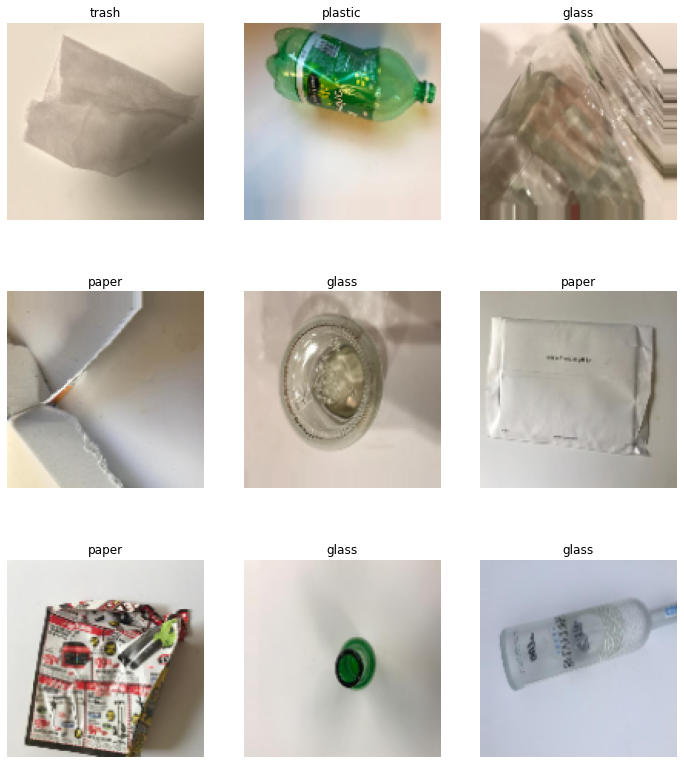

In [24]:
def visualize_images(images, labels):
    figure, ax = plt.subplots(nrows=3, ncols=3, figsize=(12, 14))
    classes = list(tr_flow_gen.class_indices.keys())
    img_no = 0
    for i in range(3):
        for j in range(3):
            img = images[img_no]
            label_no = np.argmax(labels[img_no])

            ax[i,j].imshow(img)
            ax[i,j].set_title(classes[label_no])
            ax[i,j].set_axis_off()
            img_no += 1

images, labels = next(tr_flow_gen)
visualize_images(images, labels)

In [25]:
mobilenet = MobileNetV2(include_top=False,
                        input_shape=(128,128,3),
                        classes=6,
                        weights='imagenet')
mobilenet.trainable = True
mobilenet_model = tf.keras.models.Sequential([mobilenet,
                                    GlobalAveragePooling2D(),
                                    Dense(128, activation='relu'),
                                    BatchNormalization(),
                                    Dropout(0.5),
                                    Dense(6, activation='softmax')
                                   ])
mobilenet_model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy']
             )
mobilenet_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_6 (Dense)             (None, 128)               163968    
                                                                 
 batch_normalization_3 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                      

In [26]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy',patience = 1,verbose = 1)
early_stop = EarlyStopping(monitor = 'val_accuracy',patience = 5,verbose = 1,restore_best_weights = True)
check_point = ModelCheckpoint('best_model.h5',monitor='val_accuracy',verbose=1,save_best_only=True)

In [27]:
mobilenet_hist = mobilenet_model.fit(tr_flow_gen, epochs=50, validation_data = val_flow_gen, callbacks=[early_stop,reduce_lr,check_point])

Epoch 1/50
61/61 [==============================] - ETA: 0s - loss: 1.3834 - accuracy: 0.5745
Epoch 1: val_accuracy improved from -inf to 0.26305, saving model to best_model.h5
61/61 [==============================] - 105s 2s/step - loss: 1.3834 - accuracy: 0.5745 - val_loss: 6.4481 - val_accuracy: 0.2630 - lr: 0.0010
Epoch 2/50
61/61 [==============================] - ETA: 0s - loss: 0.8179 - accuracy: 0.7231
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 2: val_accuracy did not improve from 0.26305
61/61 [==============================] - 98s 2s/step - loss: 0.8179 - accuracy: 0.7231 - val_loss: 15.9704 - val_accuracy: 0.2192 - lr: 0.0010
Epoch 3/50
61/61 [==============================] - ETA: 0s - loss: 0.5395 - accuracy: 0.8239
Epoch 3: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 3: val_accuracy did not improve from 0.26305
61/61 [==============================] - 99s 2s/step - loss: 0.5395 - accuracy: 0.8239 - va

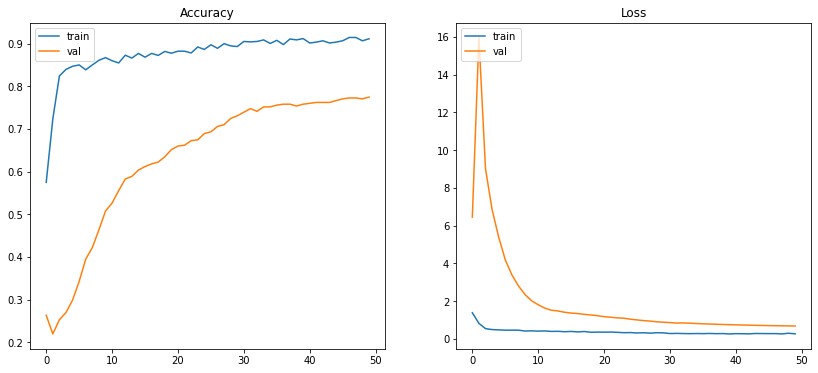

In [28]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.plot(mobilenet_hist.history['accuracy'])
plt.plot(mobilenet_hist.history['val_accuracy'])
plt.title('Accuracy')
plt.legend(['train','val'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(mobilenet_hist.history['loss'])
plt.plot(mobilenet_hist.history['val_loss'])
plt.title('Loss')
plt.legend(['train','val'], loc='upper left')
plt.show()

In [31]:
gar_test_path = '/content/drive/MyDrive/Garbage classification/Garbage classification TEST'
test_flow_gen = data_gen.flow_from_directory(directory = gar_test_path,
                                         target_size = (128, 128), # 모델에 들어갈 인풋 이미지사이즈
                                         class_mode='categorical', 
                                         batch_size=32, # 한 번에 얼마만큼의 이미지 데이터를 가져올 것인지
                                         seed = 42,
                                         shuffle=True)

Found 123 images belonging to 6 classes.


In [52]:
mobilenet_model.evaluate(test_flow_gen, verbose=1)

4/4 [==============================] - 1s 304ms/step - loss: 0.9590 - accuracy: 0.7480


[0.9589994549751282, 0.7479674816131592]

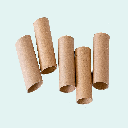

In [46]:
from keras_preprocessing import image

test_image = image.load_img('/content/drive/MyDrive/tubes.jpg', target_size = (128, 128))
test_image

In [47]:
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)

result = mobilenet_model.predict(test_image)
result = result[0]
labels = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

for i, acc in enumerate(result) :
    print(labels[i], "=", int(acc*100))
print("---")
print("예측한 결과 = " , labels[result.argmax()])

1/1 [==============================] - 0s 32ms/step
cardboard = 27
glass = 3
metal = 0
paper = 58
plastic = 1
trash = 7
---
예측한 결과 =  paper


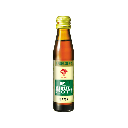

In [43]:
test_image2 = image.load_img('/content/drive/MyDrive/hwalmyeongsoo.jpg', target_size = (128, 128))
test_image2

In [44]:
test_image2 = image.img_to_array(test_image2)
test_image2 = np.expand_dims(test_image2, axis = 0)

result = mobilenet_model.predict(test_image2)
result = result[0]
labels = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

for i, acc in enumerate(result) :
    print(labels[i], "=", int(acc*100))
print("---")
print("예측한 결과 = " , labels[result.argmax()])

1/1 [==============================] - 0s 29ms/step
cardboard = 15
glass = 41
metal = 3
paper = 29
plastic = 2
trash = 8
---
예측한 결과 =  glass


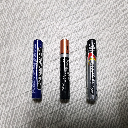

In [48]:
test_image3 = image.load_img('/content/drive/MyDrive/battery.jpeg', target_size = (128, 128))
test_image3

In [49]:
test_image3 = image.img_to_array(test_image3)
test_image3 = np.expand_dims(test_image3, axis = 0)

result = mobilenet_model.predict(test_image3)
result = result[0]
labels = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

for i, acc in enumerate(result) :
    print(labels[i], "=", int(acc*100))
print("---")
print("예측한 결과 = " , labels[result.argmax()])

1/1 [==============================] - 0s 31ms/step
cardboard = 7
glass = 0
metal = 0
paper = 87
plastic = 0
trash = 4
---
예측한 결과 =  paper
